In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

In [ ]:
class Net(nn.Module):
  def __init__(self, num_channels):
    super(Net,self).__init__()
    
    self.num_channels = num_channels
    
    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride = 1, padding = 1)
    
    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)
    
  def forward(self,x):
    #Empieza 3x64x64
    x = self.conv1(x) # num_channels x 64 x 64
    x = F.relu(F.max_pool2d(x, 2)) # num_channels x 32 x 32
    x = self.conv2(x) # num_channels*2 x 32 x32
    x = F.relu(F.max_pool2d(x, 2)) #num_channels*2 x 16 x 16
    x = self.conv3(x) # num_channels*4 x16x16
    x = F.relu(F.max_pool2d(x, 2)) # num_channels*4 x 8 x 8
    
    #flatten
    x = x.view(-1, self.num_channels*4*8*8)
    
    #fc
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    
    #log_softmax
    
    x = F.log_softmax(x, dim=1)
    
    return x
     

In [ ]:
from google.colab import drive
drive.mount("/gdrive")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
!ls "/gdrive/MyDrive/Projectes/Platzi/DeepLearning/Curso de Deep Learning con Pytorch/dl-pytorch/datasets/64x64_SIGNS"

test_signs  train_signs  val_signs


In [ ]:
import sys

course_path = '/gdrive/MyDrive/Projectes/Platzi/DeepLearning/Curso de Deep Learning con Pytorch/dl-pytorch'

sys.path.append(course_path)

In [ ]:
from plot_helpers import imshow

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class SIGNSDataset(Dataset):
  def __init__(self, base_dir, split="train", transform=None):
    path = os.path.join(base_dir, "{}_signs".format(split))
    files = os.listdir(path)
    
    self.filenames = [os.path.join(path,f) for f in files if f.endswith(".jpg")]
    
    self.targets = [int(f[0]) for f in files]
    self.transform = transform
    
  def __len__(self):
    return len(self.filenames)
  
  def __getitem__(self,idx):
    image = Image.open(self.filenames[idx])
    if self.transform:
      image = self.transform(image)
    return image, self.targets[idx]

In [ ]:
signs = SIGNSDataset("/gdrive/MyDrive/Projectes/Platzi/DeepLearning/Curso de Deep Learning con Pytorch/dl-pytorch/datasets/64x64_SIGNS",split="train")

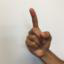

In [ ]:
signs[0][0]

In [ ]:
import torchvision.transforms as transforms

In [ ]:
trainset = SIGNSDataset("/gdrive/MyDrive/Projectes/Platzi/DeepLearning/Curso de Deep Learning con Pytorch/dl-pytorch/datasets/64x64_SIGNS", split="train", transform = transforms.ToTensor())

In [ ]:
dataloader = DataLoader(trainset, batch_size=32)

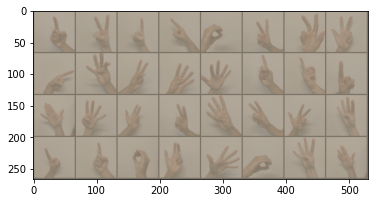

tensor([1, 2, 1, 1, 0, 2, 3, 3, 1, 4, 2, 4, 5, 1, 1, 1, 5, 4, 3, 2, 4, 2, 3, 4,
        1, 1, 0, 3, 5, 0, 4, 5])


In [ ]:
from torchvision.utils import make_grid

for inputs, targets in dataloader:
  out = make_grid(inputs)
  imshow(out)
  print(targets)
  break
     

In [ ]:
import torch.optim as optim

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
net = Net(32).to(device)

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum = 0.9)

In [ ]:
class RunningMetric():
  def __init__(self):
    self.S = 0
    self.N = 0
    
  def update(self, val, size):
    self.S += val
    self.N += size
    
  def __call__(self):
    return self.S/float(self.N)

In [ ]:
num_epochs = 100

In [ ]:

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  print('-'*10)
  
  running_loss = RunningMetric() # perdida
  running_acc = RunningMetric() #precision
  
  for inputs, targets in dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    
    outputs = net(inputs)
    _, preds = torch.max(outputs,1)
    loss = loss_fn(outputs, targets)
    
    loss.backward() #magias: gradientes calculados automaticamente
    optimizer.step() #magia2: actualiza las perillas o los parametros
    
    batch_size = inputs.size()[0]
    running_loss.update(loss.item()*batch_size,
                       batch_size)
    running_acc.update(torch.sum(preds == targets).float(),
                       batch_size)
  print("Loss: {:.4f} Acc: {:.4f} ".format(running_loss(),
                                          running_acc()))

Epoch 1/100
----------
Loss: 1.7927 Acc: 0.1632 
Epoch 2/100
----------
Loss: 1.7917 Acc: 0.1725 
Epoch 3/100
----------
Loss: 1.7910 Acc: 0.1736 
Epoch 4/100
----------
Loss: 1.7906 Acc: 0.1725 
Epoch 5/100
----------
Loss: 1.7901 Acc: 0.1725 
Epoch 6/100
----------
Loss: 1.7897 Acc: 0.1725 
Epoch 7/100
----------
Loss: 1.7893 Acc: 0.1725 
Epoch 8/100
----------
Loss: 1.7889 Acc: 0.1725 
Epoch 9/100
----------
Loss: 1.7884 Acc: 0.1736 
Epoch 10/100
----------
Loss: 1.7879 Acc: 0.1794 
Epoch 11/100
----------
Loss: 1.7874 Acc: 0.1887 
Epoch 12/100
----------
Loss: 1.7869 Acc: 0.1933 
Epoch 13/100
----------
Loss: 1.7863 Acc: 0.2049 
Epoch 14/100
----------
Loss: 1.7856 Acc: 0.2083 
Epoch 15/100
----------
Loss: 1.7849 Acc: 0.2176 
Epoch 16/100
----------
Loss: 1.7841 Acc: 0.2257 
Epoch 17/100
----------
Loss: 1.7832 Acc: 0.2338 
Epoch 18/100
----------
Loss: 1.7822 Acc: 0.2407 
Epoch 19/100
----------
Loss: 1.7811 Acc: 0.2442 
Epoch 20/100
----------
Loss: 1.7798 Acc: 0.2535 
Epoch 21/

In [ ]:
PATH = "/gdrive/MyDrive/Projectes/Platzi/DeepLearning/Curso de Deep Learning con Pytorch"

#Para salvar el modelo
torch.save(net.state_dict(), PATH)


RuntimeError: ignored

In [ ]:

#Para cargar el modelo
net.load_state_dict(torch.load('./metal_defects/best_model.pt'))

# Autograd y métodos de optimización

In [ ]:
x = torch.Tensor(2)
x.requires_grad=True
loss= 13*x[0] + 7*x[1] +1
loss.backward()
print(x)
x.grad

In [ ]:

x = torch.rand((2,3), requires_grad=True)
y = torch.Tensor([[1,2],[3,4]])
loss = y.mm(x)
loss = loss.sum()
loss.backward()
x.grad

In [ ]:
train = True

with torch.set_grad_enabled(train):
  #computos con tesonres  
     

In [ ]:

import optimizers_viz as optviz

In [ ]:

problem = optviz.build_beales_problem()
constructors = optviz.build_optimizers(problem.lr)
params = optviz.build_params(problem)

In [ ]:

optviz.plot_minimized_function(params)

In [ ]:

constructors

In [ ]:
zpaths, results, distance, lrs = optviz.run_optimizers(problem, constructors, params)

In [ ]:
optviz.plot_optim_journeys(zpaths, results, distance, lrs, params)

In [ ]:
trainset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="train", transform = transforms.ToTensor())
trainloader = DataLoader(trainset,batch_size=32)

In [ ]:

valset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="val", transform = transforms.ToTensor())
valloader = DataLoader(trainset,batch_size=32)

In [ ]:
testset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="test", transform = transforms.ToTensor())
testloader = DataLoader(trainset,batch_size=32)

In [ ]:
dataloaders = {'train':trainloader,
              'val':valloader,
              'test':testloader}

In [ ]:

transform = transforms.Compose(
  [transforms.RandomHorizontalFlip(), #data augmentation
   transforms.ToTensor(),
   transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))    
  ]
)
     

In [ ]:
class Net(nn.Module):
  def __init__(self, num_channels):
    super(Net,self).__init__()
    
    self.num_channels = num_channels
    
    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride = 1, padding = 1)
    self.bn1 = nn.BatchNorm2d(self.num_channels)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride = 1, padding = 1)
    self.bn2 = nn.BatchNorm2d(self.num_channels*2)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride = 1, padding = 1)
    self.bn3 = nn.BatchNorm2d(self.num_channels*4)
    
    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
    self.fcbn1 = nn.BatchNorm1d(self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)
    
  def forward(self,x):
      #Empieza 3x64x64
      x = self.bn1(self.conv1(x)) # num_channels x 64 x 64
      x = F.relu(F.max_pool2d(x, 2)) # num_channels x 32 x 32
      x = self.bn2(self.conv2(x)) # num_channels*2 x 32 x32
      x = F.relu(F.max_pool2d(x, 2)) #num_channels*2 x 16 x 16
      x = self.bn3(self.conv3(x)) # num_channels*4 x16x16
      x = F.relu(F.max_pool2d(x, 2)) # num_channels*4 x 8 x 8

      #flatten
      x = x.view(-1, self.num_channels*4*8*8)

      #fc
      x = F.relu(self.fcbn1(self.fc1(x)))
      x = F.dropout(x, p = 0.8, training=True)
      x = self.fc2(x)

      #log_softmax

      x = F.log_softmax(x, dim=1)

      return x   
     

In [ ]:
def train_and_evaluate(model, optimizer, loss_fn, dataloaders, device, num_epochs = 10, lr = 0.001):
  for g in optimizer.param_groups:
    g['lr'] = lr
    
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-'*10)
    
    for phase in ['train','val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = RunningMetric() # perdida
      running_acc = RunningMetric() #precision

      for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          outputs = net(inputs)
          _, preds = torch.max(outputs,1)
          loss = loss_fn(outputs, targets)
          if phase == 'train':
            loss.backward() #magias: gradientes calculados automaticamente
            optimizer.step() #magia2: actualiza las perillas o los parametros

        batch_size = inputs.size()[0]
        running_loss.update(loss.item()*batch_size,
                           batch_size)
        running_acc.update(torch.sum(preds == targets).float(),
                           batch_size)
      print("Loss: {:.4f} Acc: {:.4f} ".format(running_loss(),
                                              running_acc()))
  return model
     

In [ ]:
import random

lrs = [10**(-random.randint(3,7)) for _ in range(3)]

In [ ]:
for lr in lrs:
  train_and_evaluate(net,optimizer,loss_fn,dataloaders, device, 10, lr)

In [ ]:
from torchvision import models
vgg = models.vgg16(pretrained=True)

In [ ]:
for param in vgg.parameters():
  param.requires_grad = False

In [ ]:
last_sequential_layer = list(vgg.children())[-1]
*list_of_layers, last_layer = list(last_sequential_layer.children())
in_features = last_layer.in_features

vgg.fc = nn.Linear(in_features,6)
vgg.fc.requires_grad = True
vgg.classifier = nn.Sequential(*(list_of_layers+[vgg.fc]))

In [ ]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum = 0.9)

In [ ]:
trainset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="train", transform = transform)
trainloader = DataLoader(trainset,batch_size=32)

valset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="val", transform = transform)
valloader = DataLoader(trainset,batch_size=32)

testset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="test", transform = transform)
testloader = DataLoader(trainset,batch_size=32)

dataloaders = {'train':trainloader,
              'val':valloader,
              'test':testloader}
     

In [ ]:
inputs, tartgets = next(iter(dataloaders["train"]))

In [ ]:
vgg = vgg.to(device)
_, preds = torch.max(vgg(inputs.to(device)),1)

In [ ]:
vgg(inputs.to(device)).size()

In [ ]:
train_and_evaluate(vgg, optimizer, loss_fn, dataloaders, device, num_epochs = 100)